In [1]:
import blocksci
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections
import pandas as pd
import numpy as np
%matplotlib notebook

In [8]:
chain = blocksci.Blockchain("/root/data/bitcoin-data")

In [3]:
###比特币地址类型使用情况分类统计
#使用BlockSci的区块链对象的map_blocks()方法统计不同类型的地址 在每年的使用量：

%time net_coins_per_block = chain.map_blocks(lambda block: block.net_address_type_value())

CPU times: user 6.12 s, sys: 681 ms, total: 6.8 s
Wall time: 1min 12s


<IPython.core.display.Javascript object>


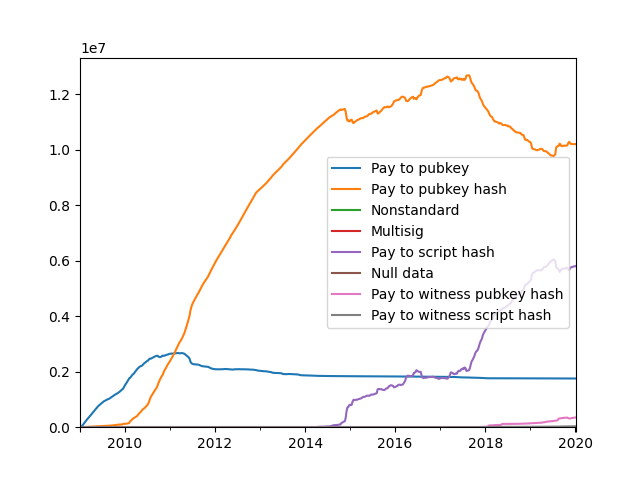

(0.0, 13313558.289755534)

In [4]:
df = pd.DataFrame(net_coins_per_block).fillna(0).cumsum()/1e8
#Convert a pandas data frame with a block height index into a frame with a block time index
df = chain.heights_to_dates(df)
df = df.rename(columns={t:str(t) for t in df.columns})
ax = df.resample("W").mean().plot()
ax.set_ylim(ymin=0)
#可以看到P2PKH地址的使用从2017年中开始减少，而P2SH地址的 使用同期则开始增加 
#  —— 这应该对应着各种钱包对隔离见证地址支持的增加。

<IPython.core.display.Javascript object>


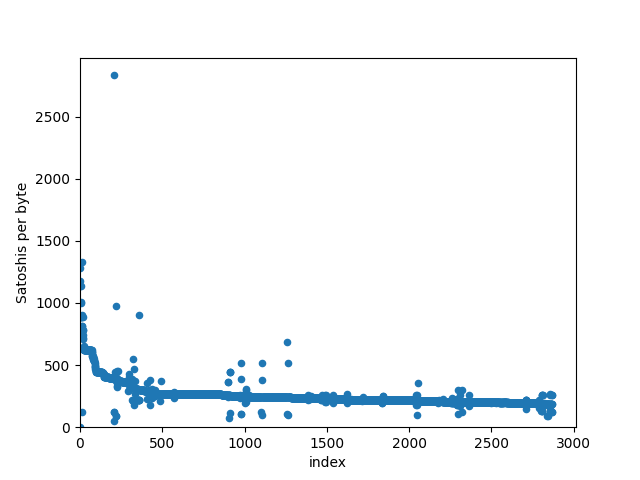

In [5]:
###比特币单区块交易手续费率可视化分析
#下面的代码使用BlockSci的区块链对象的[]操作符提取比特币465100
#区块内各交易的手续费率并进行可视化分析：

example_block_height = 465100
df = pd.DataFrame(chain[example_block_height].txes.fee_per_byte(), columns=["Satoshis per byte"])
ax = df.reset_index().plot.scatter(x="index", y="Satoshis per byte")
ax.set_ylim(0)
ax.set_xlim(0)
plt.show()

#可以看到该区块内绝大多数交易的手续费率设置在500SAT/BYTE以内。

In [9]:
###比特币二层协议使用情况可视化分析
#在比特币交易内可以嵌入二层协议以实现对其他应用的支持，
#例如omni layer 的usdt代币就是最常见的一种比特币二层协议应用。
#下面的代码 使用BlockSci的区块链对象的blocks.txes属性提取在交易输出中 
#包含OP_RETURN脚本的交易，并显示二层协议的使用情况，

%time txes = chain.blocks.txes.including_output_of_type(blocksci.address_type.nulldata).all

CPU times: user 48 s, sys: 6.37 s, total: 54.4 s
Wall time: 1min 7s


In [10]:
%time labels = [(tx.block.time, blocksci.label_application(tx)) for tx in txes]

CPU times: user 13min 15s, sys: 1min 6s, total: 14min 21s
Wall time: 18min 52s


<IPython.core.display.Javascript object>


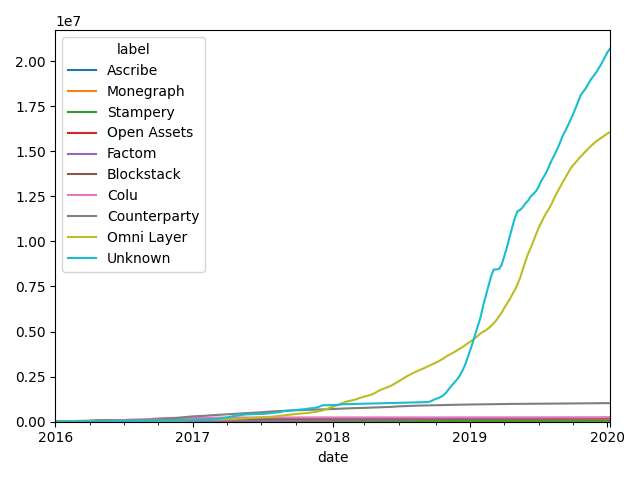

In [19]:
df = pd.DataFrame(labels, columns=["date", "label"])
df = df.reset_index().groupby(["date", "label"]).count().unstack(level=-1).fillna(0)
df.columns = df.columns.droplevel()
important_columns = list(df[df.index > pd.to_datetime("1-1-2016")].sum().sort_values()[-10:].index)
important_columns = [x for x in important_columns if "Address" not in x]
ax = df[df.index > pd.to_datetime("1-1-2016")].cumsum().resample("w").mean()[important_columns].plot()
ax.set_ylim(0)
plt.tight_layout()

In [12]:
###比特币2019年各月平均交易手续费可视化分析
#下面的代码统计年度平均手续费并将手续费换算为美元，
#注意 其中利用了BlockSci分析库中的CurrencyConverter进行汇率换算：

converter = blocksci.CurrencyConverter()

In [21]:
# BlockSci vectorized interface
blocks = chain.range('2019')
%time fees = blocks.fee / blocks.tx_count
times = blocks.time

CPU times: user 5.31 s, sys: 2.5 s, total: 7.8 s
Wall time: 30.2 s


<IPython.core.display.Javascript object>


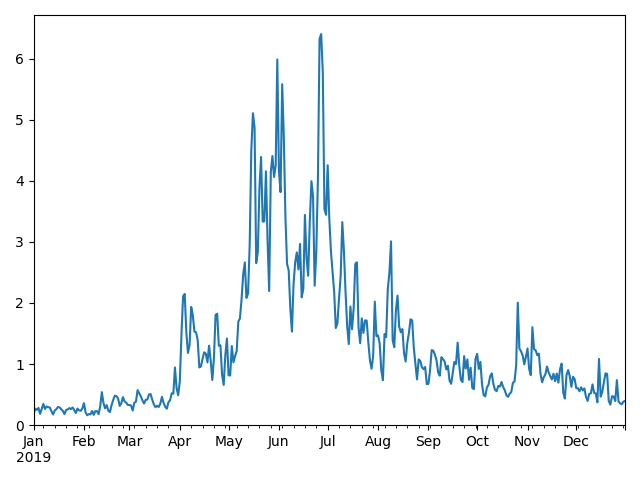

In [22]:
df = pd.DataFrame({"Fee":fees}, index=times)
df = converter.satoshi_to_currency_df(df, chain)
ax = df.resample("d").mean().plot(legend=False)
ax.set_ylim(ymin=0)
plt.tight_layout()

In [15]:
###比特币大额手续费交易可视化分析
#下面的代码分析并可视化历年来手续费超过1000美元的比特币交易：

%time high_fee_txes = chain.cpp.filter_tx("fee(tx) > 10000000", 0, len(chain))




CPU times: user 4min 44s, sys: 32.8 s, total: 5min 17s
Wall time: 3min 23s


In [23]:
converter = blocksci.CurrencyConverter()

<IPython.core.display.Javascript object>


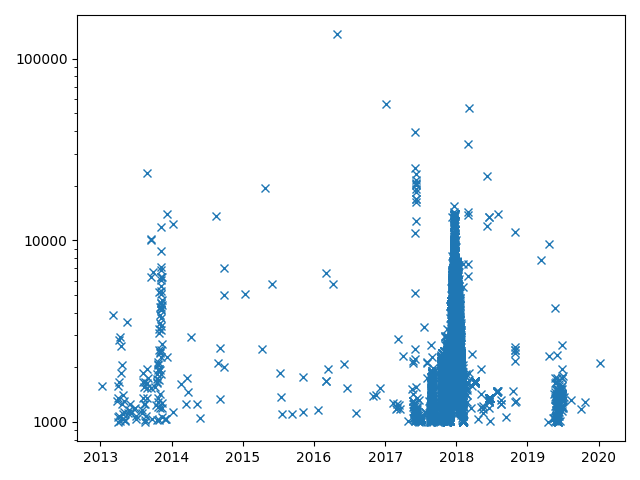

In [24]:
df = pd.DataFrame([(tx.block.height, tx.fee) for tx in high_fee_txes], columns=["height", "fee"])
df.index = df["height"]
df["fee"] = df.apply(lambda x: converter.satoshi_to_currency(x["fee"], chain[x["height"]].time), axis=1)
df = df[df["fee"] > 1000]
df = chain.heights_to_dates(df)
fig, ax = plt.subplots()
ax.plot_date(df.index, df["fee"], fmt="x")
ax.set_yscale("log")
formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
plt.tight_layout()

#2017年超过1000美元手续费的交易激增，
#从一个侧面说明了这一年 涌入了大量数字加密货币的新手。